# 4. Activation functions and non-linearities

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### New mock dataset generation - Nonlinearity

...

In [2]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 100
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[-0.77  0.1 ]
 [ 0.95  0.6 ]
 [ 0.46 -0.37]
 [-0.3  -0.92]
 [ 0.42  0.62]
 [ 0.6   0.59]
 [ 0.29 -0.44]
 [-0.17 -0.09]
 [ 0.41 -0.2 ]
 [-0.51  0.91]]
[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

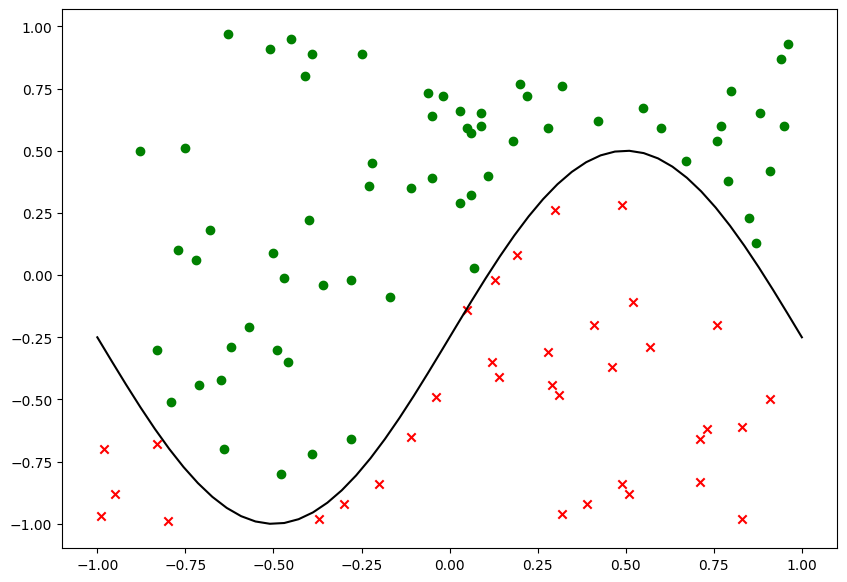

In [30]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
for v1, v2, out in zip(val1_list, val2_list, outputs):
    plt.scatter(v1, v2, c = colors[out[0]], marker = markers[out[0]])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### ShallowNeuralNet class without activation functions

If we were to reuse our previous **ShallowNeuralNet** class, we would make the assumption that the prices, surfaces and distances are connected via a linear function of some sort. Indeed, the two $ WX + b $ operations, in sequence, enventually produce a prediction, which is a linear function of the inputs.

To demonstrate, let us consider that $ n_x = 2 $, $ n_h = 4 $ and $ n_y = 1 $. In this configuration, we have:

$$ W_1 = \left( \begin{array}{cc} w^{(1)}_{1, 1}, & w^{(1)}_{1, 2}, & w^{(1)}_{1, 3}, & w^{(1)}_{1, 4} \\
w^{(1)}_{2, 1}, & w^{(1)}_{2, 2}, & w^{(1)}_{2, 3}, & w^{(1)}_{2, 4}\end{array} \right) $$

$$ b_1 = \left( \begin{array}{cc} b^{(1)}_{1, 1}, & b^{(1)}_{1, 2}, & b^{(1)}_{1, 3}, & b^{(1)}_{1, 4} \end{array} \right) $$

$$ W_2 = \left( \begin{array}{cc} w^{(2)}_{1, 1} \\ w^{(2)}_{1, 2} \\ w^{(2)}_{1, 3} \\ w^{(2)}_{1, 4} \end{array} \right) $$

$$ b_2 = \left( \begin{array}{cc} b^{(2)}_{1, 1} \end{array} \right) $$

After the first operation $ Z_1 = XW_1 + b_1 $, we have:

$$ Z_1 = \left( \begin{array}{cc} w^{(1)}_{1, 1} s + w^{(1)}_{2, 1} d + b^{(1)}_{1, 1}, & w^{(1)}_{1, 2} s + w^{(1)}_{2, 2} d + b^{(1)}_{1, 2}, & w^{(1)}_{1, 3} s + w^{(1)}_{2, 3} d + b^{(1)}_{1, 3}, & w^{(1)}_{1, 4} s + w^{(1)}_{2, 4} d + b^{(1)}_{1, 4} \end{array} \right) $$

After the second operation, the predicted price $ y_{pred} $ is given by $ y_{pred} = Z_1 W_2 + b_2 $

$$ y_{pred} = \left( \sum_{k=1}^4 w^{(1)}_{1, k} w^{(2)}_{1, k} \right) s + \left( \sum_{k=1}^4 w^{(1)}_{2, k} w^{(2)}_{1, k} \right) d + \left( \sum_{k=1}^4 b^{(1)}_{1, k} w^{(2)}_{1, k} \right) + b^{(2)}_{1, 1} $$

In [7]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
            
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        #  Adding clipping to keep prediction values
        # between 0 and 1 (see loss function!)
        pred = np.clip(Z2_b, 0, 1)
        return pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-5
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        if(np.isnan(losses).any()):
            print(losses)
            print(pred)
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (1/m)*np.dot(Z1_b.T, epsilon)
        dL_db2 = (1/m)*np.sum(epsilon, axis = 0, keepdims = True)
        dL_dZ1 = np.dot(epsilon, self.W2.T)
        dL_dW1 = (1/m)*np.dot(inputs.T, dL_dZ1)
        dL_db1 = (1/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Compute all max variations
        max_gd_vars = np.max([np.max(np.abs(alpha*dL_dW1)), \
                              np.max(np.abs(alpha*dL_db1)), \
                              np.max(np.abs(alpha*dL_dW2)), \
                              np.max(np.abs(alpha*dL_db2))])
        
        if(np.isnan(dL_dW2).any()):
            print(dL_dW2)
        if(np.isnan(dL_db2).any()):
            print(dL_db2)
        if(np.isnan(dL_dW1).any()):
            print(dL_dW1)
        if(np.isnan(dL_db1).any()):
            print(dL_db1)
        
        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.CE_loss(inputs, outputs)
        
        return max_gd_vars
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            max_gd_vars = self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            if(max_gd_vars < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [13]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net.train(N_max = 10000, alpha = 5e-3, beta = 1e-8, display = False)
print(shallow_neural_net.loss)

0.29783823594717523


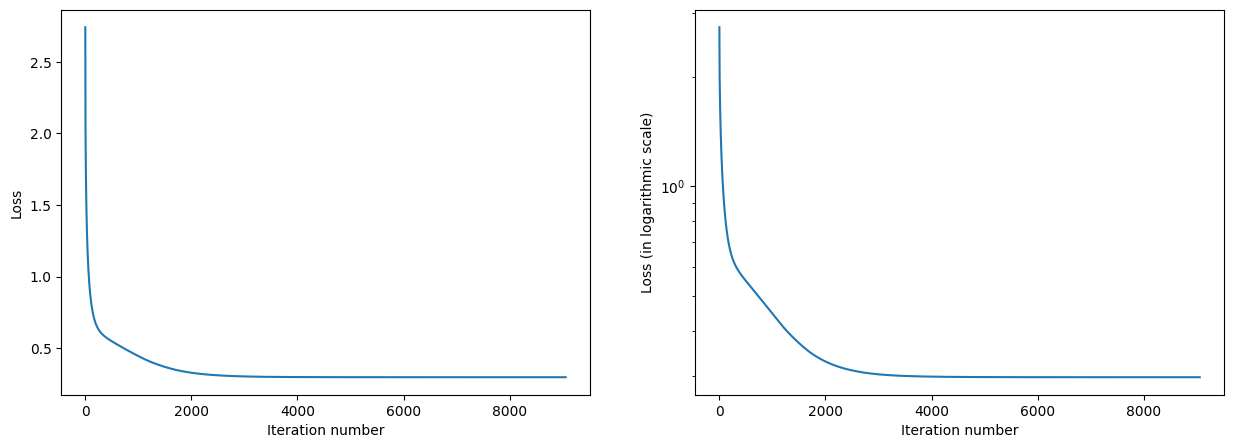

In [14]:
shallow_neural_net.show_losses_over_training()

### Why use an activation function

Activation functions are an important component of neural networks because they introduce non-linearity to the model. This is important because most real-world data is non-linear, so a model that can model non-linear relationships is more likely to be accurate.

In [15]:
class ShallowNeuralNet_WithAct():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Gradient descent update rules
        self.W2 -= (1/m)*alpha*np.dot(A1.T, gradient_output)
        self.W1 -= (1/m)*alpha*np.dot(inputs.T, gradient_hidden)
        self.b2 -= (1/m)*alpha*np.sum(gradient_output, axis = 0, keepdims = True)
        self.b1 -= (1/m)*alpha*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//1000) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [32]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_act = ShallowNeuralNet_WithAct(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_act.train(N_max = 100000, alpha = 5, beta = 1e-8, display = False)
print(shallow_neural_net_act.loss)

0.0026791054461973666


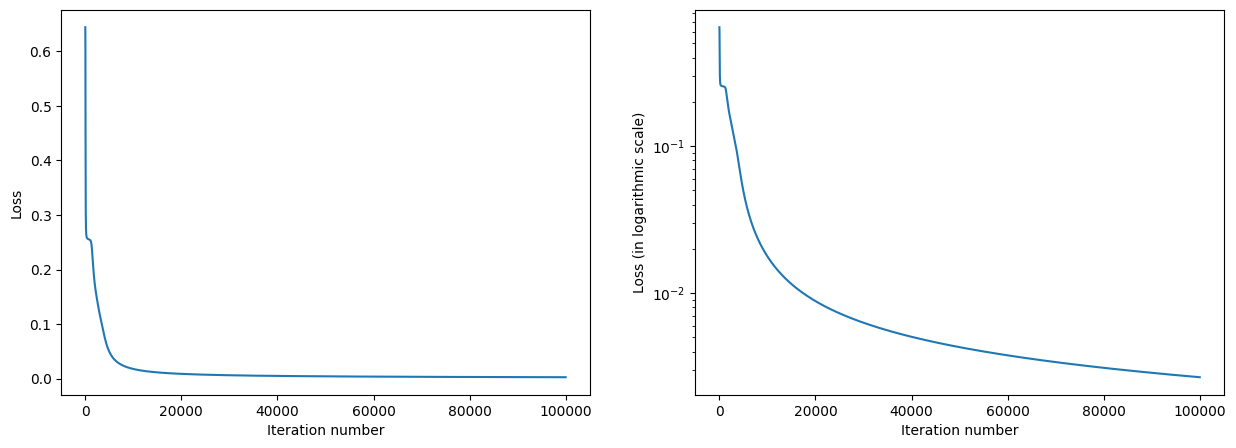

In [33]:
shallow_neural_net_act.show_losses_over_training()

In [34]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

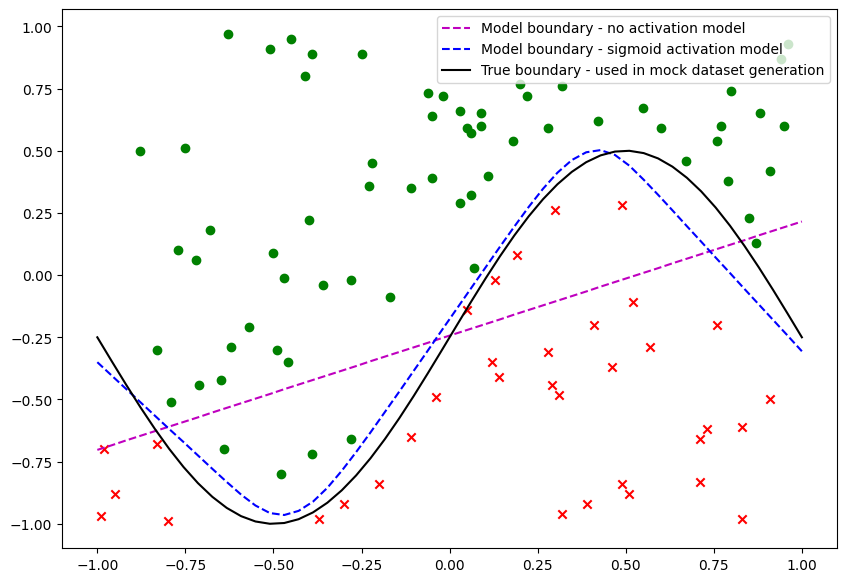

In [35]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
for v1, v2, out in zip(val1_list, val2_list, outputs):
    plt.scatter(v1, v2, c = colors[out[0]], marker = markers[out[0]])

# Display model boundary (no act model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_noact = [find_v2(v1, shallow_neural_net, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_noact, "m--", label = "Model boundary - no activation model")

# Display model boundary (sigmoid model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_act = [find_v2(v1, shallow_neural_net_act, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_act, "b--", label = "Model boundary - sigmoid activation model")

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate the impact of using activation functions in Neural Networks and implement them in our class.

This vanishing gradient problem is something we will explore again on Week 4, when discussing residuals and how they help address the vanishing gradient problem in CNNs.